In [25]:
import numpy as np
import sympy as sp
from scipy.integrate import nquad,quad
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
def generate_basis(method,begin,end,n):
    x = sp.Symbol('x')
    basis_list = []
    if method == 'linear':
        skip = (end-begin)/n
        for i in tqdm(range(n+1)):
            temp_begin = begin+(i-1)*skip
            temp_end = temp_begin+2*skip
            basis_list.append(sp.Piecewise((0, x < temp_begin),(0, x > temp_end),(1-sp.Abs(x-temp_begin-skip)/skip, True)))
    if method == 'trigo':
        feature = 2*sp.pi/(end-begin)
        for i in tqdm(range(n+1)):
            basis_list.append(sp.cos(i*feature*x))
        for i in tqdm(range(1,n+1)):
            basis_list.append(sp.sin(i*feature*x))
    return basis_list

In [27]:
def construct_A(n,basis_list):
    matrix_A = sp.zeros(n+1)
    pos = []
    for p in range(0, n+1):
        for q in range(0, n+1):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = create_value(matrix_A,item,basis_list)
    return matrix_A

In [28]:
def create_value(matrix_A,pos,basis_list):
    fi = basis_list[pos[0]]
    fj = basis_list[pos[1]]
    n_y = K*fi.subs(x,y)*fj
    n_y_numpy = sp.lambdify((x,y),n_y,'numpy')
    #n_result = n_taylor_x.integrate((x,begin,end))
    options={'limit':100}
    n_result,_ = nquad(n_y_numpy,[[begin,end],[begin,end]], opts = [options,options])
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [29]:
def Galerkin_method(n):
    basis_list = generate_basis(method,begin,end,n)
    if method == 'linear':
        m = n
        h = (end - begin)/n
        Gamma = np.zeros((n+1,n+1))
        Gamma = Gamma+ np.diag(np.ones(n+1)*2*h/3,0)
        temp = np.diag(np.ones(n)*h/6,1)
        Gamma = Gamma+temp+temp.T
        Gamma[0,0] = Gamma[0,0]-h/3
        Gamma[n,n] = Gamma[n,n]-h/3
        Lambda_diag = Lambda*Gamma
    elif method == 'trigo':
        m = 2*n
        Gamma = np.zeros((2*n+1,2*n+1))
        Gamma = Gamma+np.diag(np.ones(2*n+1)*(end-begin)/2)
        Gamma[0,0] = end-begin
        Lambda_diag = Lambda*Gamma
    K_matrix = construct_A(m,basis_list)
    A_n = Lambda_diag-K_matrix
    # 计算得到 c
    y_ = sp.zeros(m+1,1)
    for i in tqdm(range(m+1)):
        g_mod = g * basis_list[i]
        g_mod_numpy = sp.lambdify(x,g_mod,'numpy')
        result,_ = quad(g_mod_numpy,begin,end)
        y_[i, 0] = result
    A_n_acce = np.matrix(A_n).astype(np.float64)
    A_n_acce_inv = A_n_acce**(-1)
    A_n_inv = sp.Matrix(A_n_acce_inv)
    c = A_n_inv*y_
    result = 0
    for i in range(m+1):
        result = result + basis_list[i]*c[i,0]
    return result   

In [30]:
def iteration(f_origin,n):
#     N = 250
#     tolerance = 10**(-8)
    f_iter_list = []
#     xx = np.linspace(begin,end,N)
    for item in tqdm(xx):
        try:
            f_iter_list.append(result.evalf(subs={x:item}))
        except Exception as e:
            f_iter_list.append(result.evalf(subs={x:item+tolerance}))
    plt.plot(xx,f_iter_list,label=f'{n}')
    f_iter_list = iter_IE(f_iter_list)
    return f_iter_list

In [31]:
def iter_IE(f_iter):
    f_iter_new = []
    yy = np.linspace(begin,end,N)
    foot = (end-begin)/N
    for item in tqdm(xx):
        result = 0
        for i in range(N):
            try:
                result = result + K.evalf(subs={x:item,y:yy[i]})*f_iter[i]*foot
            except Exception:
                result = result + K.evalf(subs={x:item+tolerance,y:yy[i]+tolerance})*f_iter[i]*foot
        try:
            f_iter_new.append(1/Lambda*(g.evalf(subs={x:item})+result))
        except Exception as e:
            f_iter_new.append(1/Lambda*(g.evalf(subs={x:item+tolerance})+result))
    return f_iter_new

In [32]:
x = sp.Symbol('x')
y = sp.Symbol('y')

In [33]:
Lambda = 1
K =sp.exp( x*y)
begin = 0
end = 1
f_origin = 1+5*x+sp.exp(x)
method = 'trigo'
start = 5
total = 5
span = 2
y_tol = 10

In [34]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
g

5*x - Piecewise((7 - 11*exp(-1), Eq(x, -1)), (5/2 + E, Eq(x, 0)), (E*x**2*exp(x)/(x**3 + x**2) + 6*x**2*exp(x)/(x**3 + x**2) - 2*x**2/(x**3 + x**2) + x*exp(x)/(x**3 + x**2) + 4*x/(x**3 + x**2) - 5*exp(x)/(x**3 + x**2) + 5/(x**3 + x**2), True)) + exp(x) + 1

100%|██████████| 100/100 [00:00<00:00, 7052.69it/s]


正在处理n=5的情况：


100%|██████████| 100/100 [00:01<00:00, 58.57it/s]


正在处理n=7的情况：


100%|██████████| 100/100 [00:01<00:00, 58.58it/s]


正在处理n=9的情况：


100%|██████████| 100/100 [00:01<00:00, 58.32it/s]


正在处理n=11的情况：


100%|██████████| 100/100 [00:01<00:00, 58.01it/s]


正在处理n=13的情况：


100%|██████████| 100/100 [00:01<00:00, 57.93it/s]


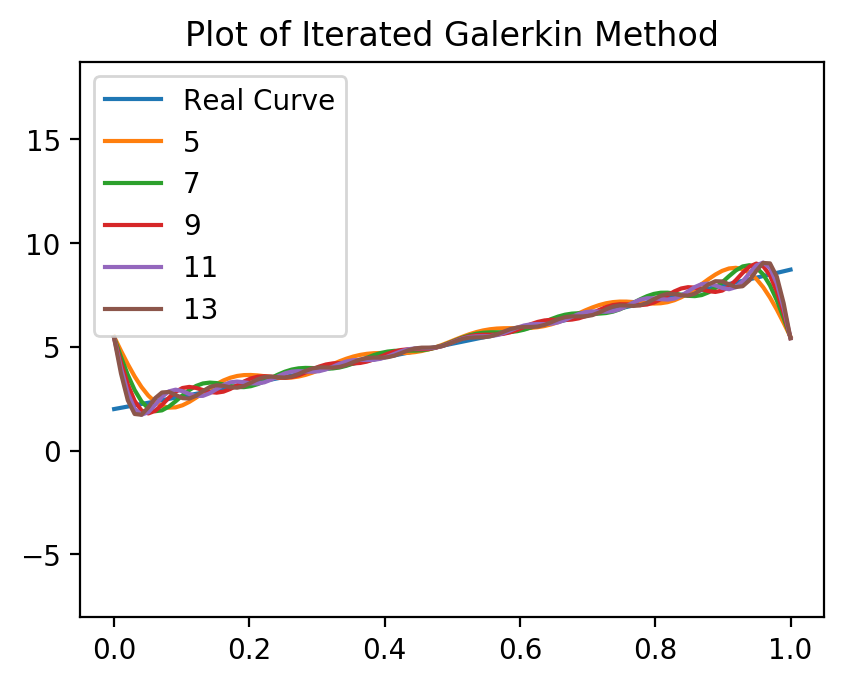

In [35]:
err_all = []
N = 50*(int(end-begin)+1)
tolerance = 10**(-8)
err_iter=[]
xx = np.linspace(begin,end,N)
f_origin_list = []
for item in tqdm(xx):
    try:
        f_origin_list.append(f_origin.evalf(subs={x:item}))
    except Exception as e:
        f_origin_list.append(f_origin.evalf(subs={x:item+tolerance}))
y_MAX = np.max(f_origin_list)
y_MIN = np.min(f_origin_list)
fig,ax = plt.subplots(1,1)
plt.title('Plot of Iterated Galerkin Method')
ax.plot(xx,f_origin_list,label=f'Real Curve')
for i in range(start,start+total*span,span):
    print(f'正在处理n={i}的情况：')
    result = Galerkin_method(i)
    f_iter_list = iteration(result,i)
    err = np.array(f_origin_list)-np.array(f_iter_list)
    err_norm2 = np.sum(err**2)/N
    err_iter.append(err_norm2)
ax.legend()
plt.ylim((float(y_MIN-y_tol),float(y_MAX+y_tol)))
plt.show()

[0.0196748632302331, 0.0105650778905622, 0.00655312659243682, 0.00444003324349619, 0.00319248133063896]


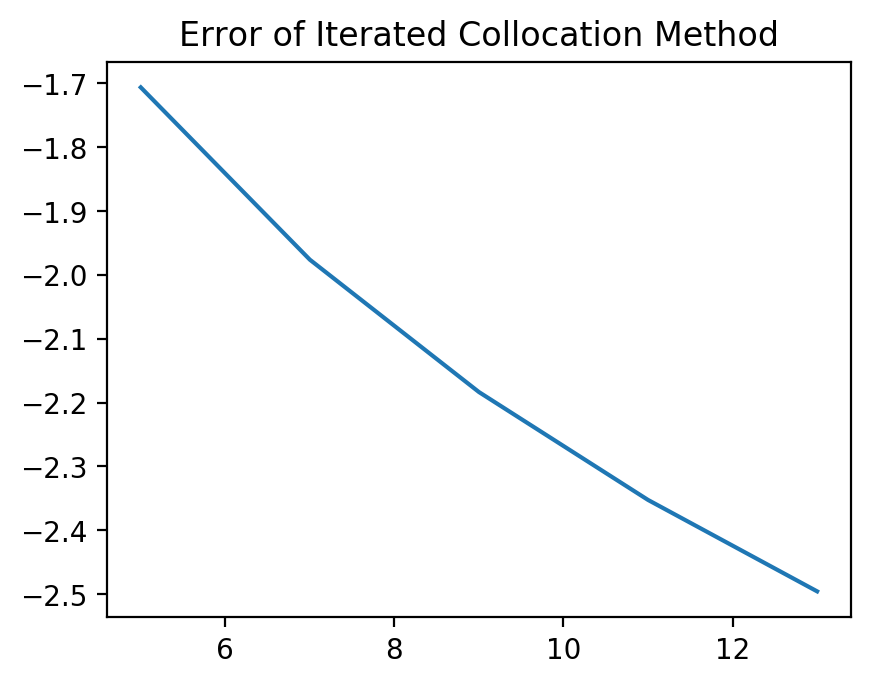

In [36]:
plt_err,ax_err = plt.subplots(1,1) 
plt.title('Error of Iterated Collocation Method')
ax_err.plot(np.arange(start,start+total*span,span),[np.log10(float(x)) for x in err_iter])
print(err_iter)